# What makes the Universe?

## Estimating few Cosmology parameters

Now that we know, Universe is accelerating, we shall try to know what is it composed of.

If it was only composed of matter then, it would have positive decceleration parameter. The acceleration is theoretically modelled using 'Dark Energy'. The easiest, simple, elegant and widely accepeted candidate for Dark Energy is the Cosmological Constant (there are some issues as well). 

So, we have following parameters to estimate,

h- dimensionless Hubble parameter

$\Omega_m$ - density fraction of matter

$\Omega_{de}$ - density fraction of dark energy

We can use the same data from Supernova Cosmology Project http://supernova.lbl.gov/

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

Here we can use apparaent magnitude as the y-axis and leave redshift in the x-axis. 

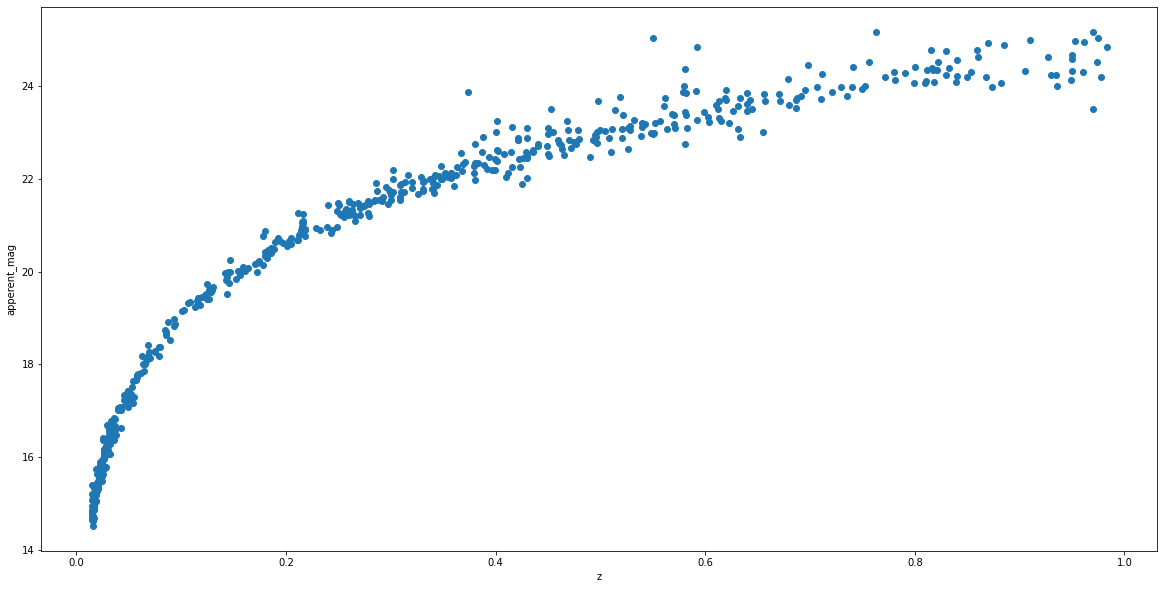

In [26]:
file1 = open('sn.txt', 'r')
Lines = file1.readlines()
 
z = []
distance_mod = []
# Strips the newline character
for line in Lines:
    x = line.split()
    if float(x[1]) < 1:
        z.append(float(x[1]))
        distance_mod.append(float(x[2]))
        
z = np.array(z)
distance_mod = np.array(distance_mod)

c = 3 * 1e5
apperent_mag = distance_mod - 19.3081547178

plt.scatter(z, apperent_mag)
plt.xlabel('z')
plt.ylabel('apperent_mag')
plt.show()

a here is just a initial condition

In [27]:
def model(theta,z=z):
    m, de, dm, h, a = theta
    q = 1 - (2 * de * (h**2)) - (0.5 * dm * (h**2))
    return np.log(m * z * (1 + (0.5 * (1 - q) * z)) * c) + a

In [28]:
def lnprior(theta):
    m, de, dm, h, a = theta
    if 0.01 < m < 0.016 and de + dm <= 1 and 0.0 <= de < 1.0 and 0.0 <= dm < 1.0  and 0.6 < h < 0.8: 
        return 0.0
    return -np.inf

In [29]:
def lnlike(theta, x, y, yerr):
    return - np.sqrt(0.5) * np.sum(((y - model(theta, x))/yerr) ** 2)

In [30]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + 1e-10 * lnlike(theta, x, y, yerr)

In [31]:
apperent_mag_err = 0.001 * np.mean(apperent_mag)
data = (z, apperent_mag,apperent_mag_err)
nwalkers = 128
niter = 500
initial = np.array([0.0125, 0, 1, 0.7, 14])
ndim = len(initial)
p0 = [np.array(initial) + 1e-10 * np.random.randn(ndim) for i in range(nwalkers)]

In [32]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 10)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [33]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


C:\Users\jeeva\Anaconda3\envs\Statistics\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


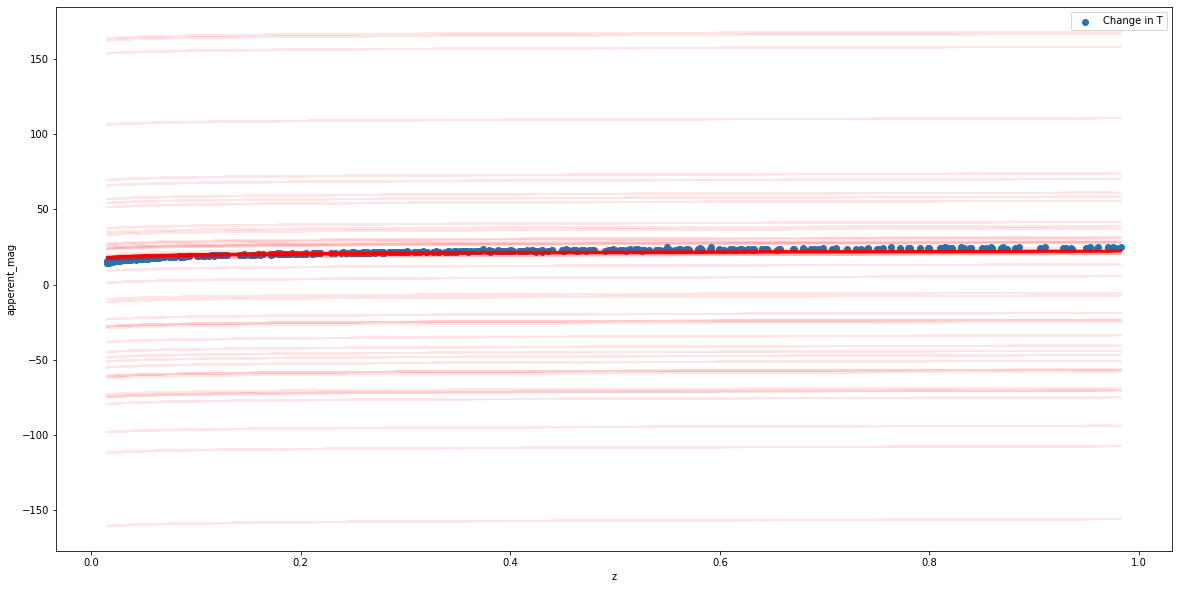

In [34]:
def plotter(sampler,z=z,apperent_mag=apperent_mag):
    plt.ion()
    plt.scatter(z,apperent_mag,label='Change in T')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(z, model(theta, z), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('z')
    plt.ylabel('apperent_mag')
    plt.legend()
    plt.show()

plotter(sampler)

We see that, we get a better estimation for current Hubble parameter than the previous exercise. It shows that, the recent Universe, is dominated with Dark Energy, which is accelerating the expansion of the Universe.  

In [35]:
samples = sampler.flatchain
best = samples[np.argmax(sampler.flatlnprobability)]
print(best)

[1.23131729e-02 6.62876222e-01 2.07513638e-01 7.00276847e-01
 1.38520882e+01]


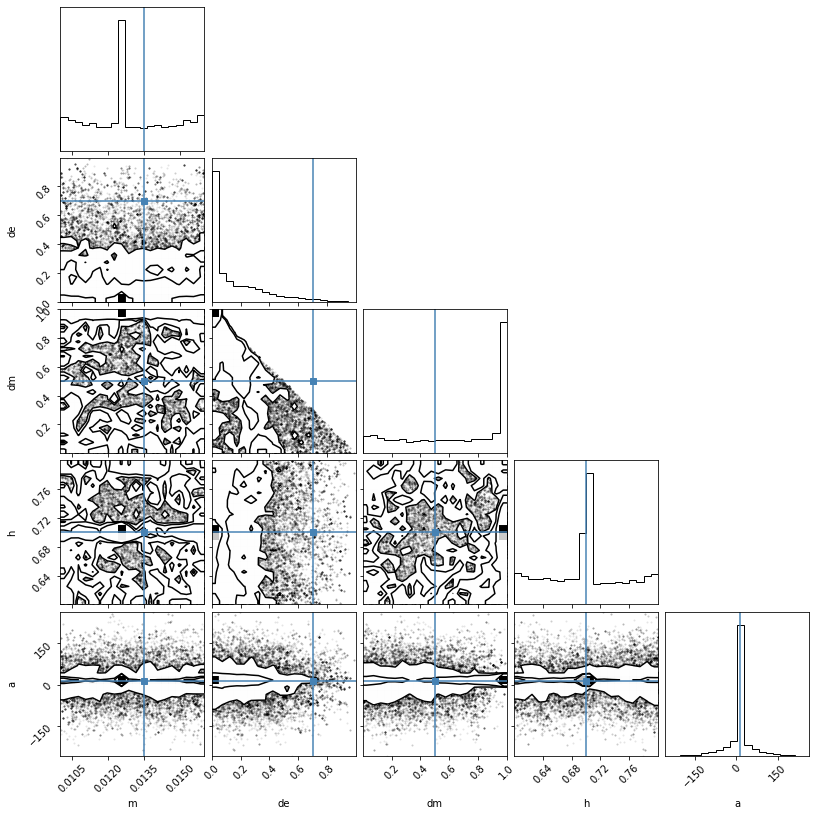

In [36]:
labels = ["m","de", "dm", "h",'a']
fig = corner.corner(
    samples, labels=labels, truths=[0.0135, 0.7, 0.5, 0.7, 14]
);